# EDA notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,inspect
sys.path.insert(0,"..")

In [3]:
!pwd

/home/hz/tryon/train_src/notebooks


In [3]:
from options.train_options import TrainOptions
opt = TrainOptions().parse()

------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
continue_train: False
data_type: 32
dataroot: ../datasets/acgpn_data/try_on_training/
debug: False
display_freq: 100
display_winsize: 512
fineSize: 512
gpu_ids: [0]
input_nc: 3
isTrain: True
label_nc: 20
lambda_feat: 10.0
loadSize: 512
load_pretrain: 
lr: 0.0002
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_layers_D: 3
n_local_enhancers: 1
name: label2city
ndf: 64
netG: global
ngf: 64
niter: 100
niter_decay: 100
niter_fix_global: 0
no_flip: False
no_ganFeat_loss: False
no_html: False
no_lsgan: False
no_vgg_loss: False
norm: instance
num_D: 2
output_nc: 3
phase: train
pool_size: 0
print_freq: 100
resize_or_crop: scale_width
save_epoch_freq: 10
save_latest_freq: 1000
serial_batches: False
tf_log: False
use_dropout: False
verbose: False
which_epoch: latest
-------------- End ----------------


In [4]:
# Change to run on notebook
opt.dataroot = "../../datasets/acgpn_data/try_on_training/"

In [5]:
### Copyright (C) 2017 NVIDIA Corporation. All rights reserved. 
### Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import random
import ipdb

class BaseDataset(data.Dataset):
    def __init__(self):
        super(BaseDataset, self).__init__()

    def name(self):
        return 'BaseDataset'

    def initialize(self, opt):
        pass

def get_params(opt, size):
    w, h = size
    new_h = h
    new_w = w
    if opt.resize_or_crop == 'resize_and_crop':
        new_h = new_w = opt.loadSize            
    elif opt.resize_or_crop == 'scale_width_and_crop':
        new_w = opt.loadSize
        new_h = opt.loadSize * h // w

    x = random.randint(0, np.maximum(0, new_w - opt.fineSize))
    y = random.randint(0, np.maximum(0, new_h - opt.fineSize))
    
    #flip = random.random() > 0.5
    flip = 0
    return {'crop_pos': (x, y), 'flip': flip}

def get_transform(opt, params, method=Image.BICUBIC, normalize=True):
    transform_list = []
    if 'resize' in opt.resize_or_crop:
        osize = [opt.loadSize, opt.loadSize]
        transform_list.append(transforms.Scale(osize, method))   
    elif 'scale_width' in opt.resize_or_crop:
        transform_list.append(transforms.Lambda(lambda img: __scale_width(img, opt.loadSize, method)))
        osize = [256,192]
        transform_list.append(transforms.Scale(osize, method))  
    if 'crop' in opt.resize_or_crop:
        transform_list.append(transforms.Lambda(lambda img: __crop(img, params['crop_pos'], opt.fineSize)))

    if opt.resize_or_crop == 'none':
        base = float(2 ** opt.n_downsample_global)
        if opt.netG == 'local':
            base *= (2 ** opt.n_local_enhancers)
        transform_list.append(transforms.Lambda(lambda img: __make_power_2(img, base, method)))

    if opt.isTrain and not opt.no_flip:
        transform_list.append(transforms.Lambda(lambda img: __flip(img, params['flip'])))

    transform_list += [transforms.ToTensor()]

    if normalize:
        transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

def normalize():    
    return transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

def __make_power_2(img, base, method=Image.BICUBIC):
    ow, oh = img.size        
    h = int(round(oh / base) * base)
    w = int(round(ow / base) * base)
    if (h == oh) and (w == ow):
        return img
    return img.resize((w, h), method)

def __scale_width(img, target_width, method=Image.BICUBIC):
    ow, oh = img.size
    if (ow == target_width):
        return img    
    w = target_width
    h = int(target_width * oh / ow)    
    return img.resize((w, h), method)

def __crop(img, pos, size):
    ow, oh = img.size
    x1, y1 = pos
    tw = th = size
    if (ow > tw or oh > th):        
        return img.crop((x1, y1, x1 + tw, y1 + th))
    return img

def __flip(img, flip):
    if flip:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    return img


In [6]:
## Copyright (C) 2017 NVIDIA Corporation. All rights reserved. 
### Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
import os.path
#from data.base_dataset import BaseDataset, get_params, get_transform, normalize
from data.image_folder import make_dataset, make_dataset_test
from PIL import Image
import torch
import json
import numpy as np
import os.path as osp
from PIL import ImageDraw
import ipdb

class AlignedDataset(BaseDataset):
    def initialize(self, opt):
        self.opt = opt
        self.root = opt.dataroot    
        self.diction={}
        ### input A (label maps)
        if opt.isTrain or opt.use_encoded_image:
            dir_A = '_A' if self.opt.label_nc == 0 else '_label'
            self.dir_A = os.path.join(opt.dataroot, opt.phase + dir_A)
            # All paths in train/test_label
            self.A_paths = sorted(make_dataset(self.dir_A))
            # All paths in train/test_label but random
            self.AR_paths = make_dataset(self.dir_A)

        self.fine_height=256
        self.fine_width=192
        self.radius=5
        ### input A test (label maps)
        if not (opt.isTrain or opt.use_encoded_image):
            dir_A = '_A' if self.opt.label_nc == 0 else '_label'
            self.dir_A = os.path.join(opt.dataroot, opt.phase + dir_A)
            self.A_paths = sorted(make_dataset_test(self.dir_A))
            dir_AR = '_AR' if self.opt.label_nc == 0 else '_labelref'
            self.dir_AR = os.path.join(opt.dataroot, opt.phase + dir_AR)
            self.AR_paths = sorted(make_dataset_test(self.dir_AR))

        ### input B (real images)
        dir_B = '_B' if self.opt.label_nc == 0 else '_img'
        self.dir_B = os.path.join(opt.dataroot, opt.phase + dir_B)  
        self.B_paths = sorted(make_dataset(self.dir_B))
        self.BR_paths = sorted(make_dataset(self.dir_B))
        
        self.dataset_size = len(self.A_paths)
        self.build_index(self.B_paths)

        ### input E (edge_maps)
        if opt.isTrain or opt.use_encoded_image:
            dir_E = '_edge'
            self.dir_E = os.path.join(opt.dataroot, opt.phase + dir_E)
            self.E_paths = sorted(make_dataset(self.dir_E))
            self.ER_paths = make_dataset(self.dir_E)

        ### input M (masks)
        if opt.isTrain or opt.use_encoded_image:
            dir_M = '_mask'
            self.dir_M = os.path.join(opt.dataroot, opt.phase + dir_M)
            self.M_paths = sorted(make_dataset(self.dir_M))
            self.MR_paths = make_dataset(self.dir_M)

        ### input MC(color_masks)
        if opt.isTrain or opt.use_encoded_image:
            dir_MC = '_colormask'
            self.dir_MC = os.path.join(opt.dataroot, opt.phase + dir_MC)
            self.MC_paths = sorted(make_dataset(self.dir_MC))
            self.MCR_paths = make_dataset(self.dir_MC)
        
        ### input C(color)
        if opt.isTrain or opt.use_encoded_image:
            dir_C = '_color'
            self.dir_C = os.path.join(opt.dataroot, opt.phase + dir_C)
            self.C_paths = sorted(make_dataset(self.dir_C))
            self.CR_paths = make_dataset(self.dir_C)
        # self.build_index(self.C_paths)
        
        
        ### input A test (label maps)
        if not (opt.isTrain or opt.use_encoded_image):
            dir_A = '_A' if self.opt.label_nc == 0 else '_label'
            self.dir_A = os.path.join(opt.dataroot, opt.phase + dir_A)
            self.A_paths = sorted(make_dataset_test(self.dir_A))
            
    
    def random_sample(self,item):
        name = item.split('/')[-1]
        name = name.split('-')[0]
        lst=self.diction[name]
        new_lst=[]
        for dir in lst:
            if dir != item:
                new_lst.append(dir)
        return new_lst[np.random.randint(len(new_lst))]
    
    def build_index(self,dirs):
        for k,dir in enumerate(dirs):
            name=dir.split('/')[-1]
            name=name.split('-')[0]

            # print(name)
            for k,d in enumerate(dirs[max(k-20,0):k+20]):
                if name in d:
                    if name not in self.diction.keys():
                        self.diction[name]=[]
                        self.diction[name].append(d)
                    else:
                        self.diction[name].append(d)


    def __getitem__(self, index):
        train_mask=9600
        ipdb.set_trace()
        breakpoint()
        
        ### input A (label maps)
        # box=[]
        # for k,x in enumerate(self.A_paths):
        #     if '2372656' in x :
        #         box.append(k)
        # index=box[np.random.randint(len(box))]
        print(index)
        test=index#np.random.randint(10000)
        A_path = self.A_paths[index]
        AR_path = self.AR_paths[index]
        A = Image.open(A_path).convert('L')
        AR = Image.open(AR_path).convert('L')

        params = get_params(self.opt, A.size)
        if self.opt.label_nc == 0:
            transform_A = get_transform(self.opt, params)
            A_tensor = transform_A(A.convert('RGB'))
            AR_tensor = transform_A(AR.convert('RGB'))
        else:
            transform_A = get_transform(self.opt, params, method=Image.NEAREST, normalize=False)
            A_tensor = transform_A(A) * 255.0
            AR_tensor = transform_A(AR) * 255.0
        B_tensor = inst_tensor = feat_tensor = 0
        ### input B (real images)
        B_path = self.B_paths[index]
        BR_path = self.BR_paths[index]
        B = Image.open(B_path).convert('RGB')
        BR = Image.open(BR_path).convert('RGB')
        transform_B = get_transform(self.opt, params)      
        B_tensor = transform_B(B)
        BR_tensor = transform_B(BR)

        ### input M (masks)
        M_path = self.M_paths[np.random.randint(12000)]
        MR_path =self.MR_paths[np.random.randint(12000)]
        M = Image.open(M_path).convert('L')
        MR = Image.open(MR_path).convert('L')
        M_tensor = transform_A(MR)

        ### input_MC (colorMasks)
        MC_path = B_path#self.MC_paths[1]
        MCR_path = B_path#self.MCR_paths[1]
        MCR = Image.open(MCR_path).convert('L')
        MC_tensor = transform_A(MCR)

        ### input_C (color)
        # print(self.C_paths)
        C_path = self.C_paths[test]
        C = Image.open(C_path).convert('RGB')
        C_tensor = transform_B(C)

        ##Edge
        E_path = self.E_paths[test]
        # print(E_path)
        E = Image.open(E_path).convert('L')
        E_tensor = transform_A(E)


        ##Pose
        pose_name =B_path.replace('.png', '_keypoints.json').replace('.jpg','_keypoints.json').replace('train_img','train_pose')
        with open(osp.join(pose_name), 'r') as f:
            pose_label = json.load(f)
            try:
                pose_data = pose_label['people'][0]['pose_keypoints']
            except IndexError:
                pose_data = [0 for i in range(54)]
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1,3))

        point_num = pose_data.shape[0]
        pose_map = torch.zeros(point_num, self.fine_height, self.fine_width)
        r = self.radius
        im_pose = Image.new('L', (self.fine_width, self.fine_height))
        pose_draw = ImageDraw.Draw(im_pose)
        for i in range(point_num):
            one_map = Image.new('L', (self.fine_width, self.fine_height))
            draw = ImageDraw.Draw(one_map)
            pointx = pose_data[i,0]
            pointy = pose_data[i,1]
            if pointx > 1 and pointy > 1:
                draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
                pose_draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
            one_map = transform_B(one_map.convert('RGB'))
            pose_map[i] = one_map[0]
        P_tensor=pose_map
        if self.opt.isTrain:
            input_dict = { 'label': A_tensor, 'label_ref': AR_tensor, 'image': B_tensor, 'image_ref': BR_tensor, 'path': A_path, 'path_ref': AR_path,
                            'edge': E_tensor,'color': C_tensor, 'mask': M_tensor, 'colormask': MC_tensor,'pose':P_tensor
                          }
        else:
            input_dict = {'label': A_tensor, 'label_ref': AR_tensor, 'image': B_tensor, 'image_ref': BR_tensor, 'path': A_path, 'path_ref': AR_path}

        return input_dict

    def __len__(self):
        return len(self.A_paths) // self.opt.batchSize * self.opt.batchSize

    def name(self):
        return 'AlignedDataset'


In [7]:
import torch.utils.data
#from data.base_data_loader import BaseDataLoader

class BaseDataLoader():
    def __init__(self):
        pass
    
    def initialize(self, opt):
        self.opt = opt
        pass

    def load_data():
        return None


def CreateDataset(opt):
    dataset = None
    dataset = AlignedDataset()

    print("dataset [%s] was created" % (dataset.name()))
    dataset.initialize(opt)
    return dataset

class CustomDatasetDataLoader(BaseDataLoader):
    def name(self):
        return 'CustomDatasetDataLoader'

    def initialize(self, opt):
        BaseDataLoader.initialize(self, opt)
        self.dataset = CreateDataset(opt)
        self.dataloader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=opt.batchSize,
            shuffle=not opt.serial_batches,
            num_workers=0) # int(opt.nThreads) # changed for debugger

    def load_data(self):
        return self.dataloader

    def __len__(self):
        return min(len(self.dataset), self.opt.max_dataset_size)

In [8]:
opt.nThreads

2

In [9]:
def CreateDataLoader(opt):
    data_loader = CustomDatasetDataLoader()
    print(data_loader.name())
    data_loader.initialize(opt)
    return data_loader

In [10]:
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()
dataset_size = len(data_loader)
print('#training images = %d' % dataset_size)

CustomDatasetDataLoader
dataset [AlignedDataset] was created
../../datasets/acgpn_data/try_on_training/train_label label
../../datasets/acgpn_data/try_on_training/train_label label
../../datasets/acgpn_data/try_on_training/train_img img
../../datasets/acgpn_data/try_on_training/train_img img
../../datasets/acgpn_data/try_on_training/train_edge edge
../../datasets/acgpn_data/try_on_training/train_edge edge
../../datasets/acgpn_data/try_on_training/train_mask mask
../../datasets/acgpn_data/try_on_training/train_mask mask
../../datasets/acgpn_data/try_on_training/train_colormask colormask
../../datasets/acgpn_data/try_on_training/train_colormask colormask
../../datasets/acgpn_data/try_on_training/train_color color
../../datasets/acgpn_data/try_on_training/train_color color
#training images = 14221


In [11]:
type(data_loader)

__main__.CustomDatasetDataLoader

In [ ]:
data = next(iter(dataset))

In [2]:
for i in range(4):
    print(i)
    if i == 1:
        print("Exiting loop.")
        break

0
1
Exiting loop.


In [5]:
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [6]:
A = cv2.imread('../../datasets/acgpn_data/try_on_training/train_label/014857_0.png', -1)
AR = cv2.imread('../../datasets/acgpn_data/try_on_training/train_label/003922_0.png', -1)

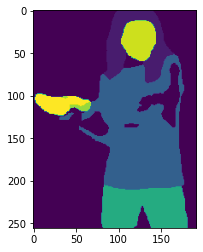

In [7]:
plt.imshow(A)

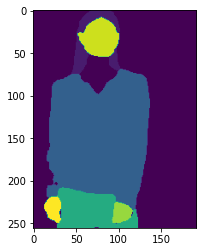

In [8]:
plt.imshow(AR)

In [9]:
B = cv2.cvtColor(cv2.cv2.imread('../../datasets/acgpn_data/try_on_training/train_img/014857_0.jpg'), cv2.COLOR_BGR2RGB)
BR = cv2.cvtColor(cv2.cv2.imread('../../datasets/acgpn_data/try_on_training/train_img/014857_0.jpg'), cv2.COLOR_BGR2RGB)

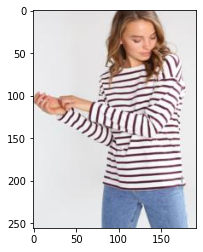

In [11]:
plt.imshow(B)

In [13]:
M = cv2.imread('../../datasets/acgpn_data/try_on_training/train_mask/09851.png', -1)
MR = cv2.imread('../../datasets/acgpn_data/try_on_training/train_mask/01482.png', -1)

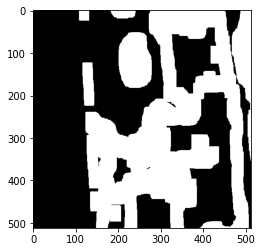

In [14]:
plt.imshow(M)

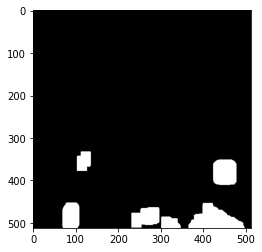

In [15]:
plt.imshow(MR)

In [16]:
MCR = cv2.cvtColor(cv2.cv2.imread('../../datasets/acgpn_data/try_on_training/train_img/014857_0.jpg'), cv2.COLOR_BGR2RGB)

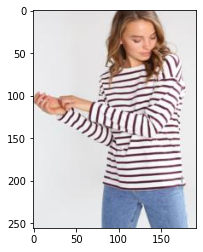

In [17]:
plt.imshow(MCR)

In [19]:
C = cv2.cvtColor(cv2.cv2.imread('../../datasets/acgpn_data/try_on_training/train_color/014857_1.jpg'), cv2.COLOR_BGR2RGB)

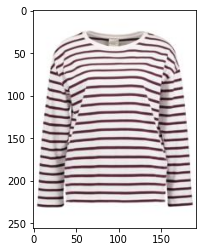

In [20]:
plt.imshow(C)

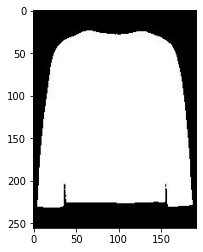

In [21]:
E = cv2.cvtColor(cv2.cv2.imread('../../datasets/acgpn_data/try_on_training/train_edge/014857_1.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(E)

In [22]:
pose_name = '../../datasets/acgpn_data/try_on_training/train_pose/014857_0_keypoints.json'
pose_name

'../../datasets/acgpn_data/try_on_training/train_pose/014857_0_keypoints.json'

In [24]:
import os.path as osp
import json
import numpy as np

with open(osp.join(pose_name), 'r') as f:
    pose_label = json.load(f)
    try:
        pose_data = pose_label['people'][0]['pose_keypoints']
    except IndexError:
        pose_data = [0 for i in range(54)]
    pose_data = np.array(pose_data)
    pose_data = pose_data.reshape((-1,3))

In [25]:
pose_data.shape

(18, 3)

In [26]:
pose_data

array([[134.5511811 ,  42.35636364,   0.90977456],
       [123.71653543,  72.84363636,   0.59415508],
       [ 90.70866142,  80.29090909,   0.50221331],
       [ 88.69291339, 147.54909091,   0.28055125],
       [  0.        ,   0.        ,   0.        ],
       [161.25984252,  62.37090909,   0.53713776],
       [132.53543307, 137.07636364,   0.28696877],
       [ 65.25984252, 112.64      ,   0.39430975],
       [102.2992126 , 202.00727273,   0.28298626],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [153.95275591, 202.70545455,   0.27581317],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [122.20472441,  35.60727273,   0.90504703],
       [139.84251969,  32.34909091,   0.91726194],
       [102.5511811 ,  34.21090909,   0.82210448],
       [  0.        ,   0.        ,   0.        ]])

In [27]:
point_num = pose_data.shape[0]
point_num

18

In [28]:
import torch
pose_map = torch.zeros(point_num, 256, 192)
pose_map.shape

torch.Size([18, 256, 192])

In [29]:
# radius
r = 5

In [30]:
im_pose = Image.new('L', (256, 192))

In [31]:
pose_draw = ImageDraw.Draw(im_pose)

In [32]:
import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import random
import ipdb

def get_params(opt, size):
    w, h = size
    new_h = h
    new_w = w
    if opt.resize_or_crop == 'resize_and_crop':
        new_h = new_w = opt.loadSize            
    elif opt.resize_or_crop == 'scale_width_and_crop':
        new_w = opt.loadSize
        new_h = opt.loadSize * h // w

    x = random.randint(0, np.maximum(0, new_w - opt.fineSize))
    y = random.randint(0, np.maximum(0, new_h - opt.fineSize))
    
    #flip = random.random() > 0.5
    flip = 0
    return {'crop_pos': (x, y), 'flip': flip}

def get_transform(opt, params, method=Image.BICUBIC, normalize=True):
    transform_list = []
    if 'resize' in opt.resize_or_crop:
        osize = [opt.loadSize, opt.loadSize]
        transform_list.append(transforms.Scale(osize, method))   
    
    elif 'scale_width' in opt.resize_or_crop:
        transform_list.append(transforms.Lambda(lambda img: __scale_width(img, opt.loadSize, method)))
        osize = [256,192]
        transform_list.append(transforms.Scale(osize, method))  
    
    if 'crop' in opt.resize_or_crop:
        transform_list.append(transforms.Lambda(lambda img: __crop(img, params['crop_pos'], opt.fineSize)))

    if opt.resize_or_crop == 'none':
        base = float(2 ** opt.n_downsample_global)
        if opt.netG == 'local':
            base *= (2 ** opt.n_local_enhancers)
        transform_list.append(transforms.Lambda(lambda img: __make_power_2(img, base, method)))

    if opt.isTrain and not opt.no_flip:
        transform_list.append(transforms.Lambda(lambda img: __flip(img, params['flip'])))

    transform_list += [transforms.ToTensor()]

    if normalize:
        transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

def __scale_width(img, target_width, method=Image.BICUBIC):
    ow, oh = img.size
    if (ow == target_width):
        return img    
    w = target_width
    h = int(target_width * oh / ow)    
    return img.resize((w, h), method)

def __flip(img, flip):
    if flip:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    return img

params = get_params(opt,(192, 256))
transform_B = get_transform(opt, params)

/home/hz/anaconda3/envs/comp6321/lib/python3.8/site-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/home/hz/anaconda3/envs/comp6321/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [33]:
opt.resize_or_crop

'scale_width'

In [34]:
for i in range(point_num):
    one_map = Image.new('L', (256, 192))
    draw = ImageDraw.Draw(one_map)
    pointx = pose_data[i,0]
    pointy = pose_data[i,1]
    if pointx > 1 and pointy > 1:
        draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
        pose_draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
    
    one_map = transform_B(one_map.convert('RGB'))
    pose_map[i] = one_map[0]

In [35]:
pose_map.shape

torch.Size([18, 256, 192])

In [36]:
torch.unique(pose_map)

tensor([-1.0000, -0.9922, -0.9843, -0.9765, -0.9686, -0.9608, -0.9451, -0.9373,
        -0.9216, -0.9137, -0.8588, -0.8431, -0.8039, -0.7882, -0.7804, -0.7725,
        -0.7647, -0.7569, -0.7255, -0.6863, -0.6784, -0.6471, -0.5137, -0.4353,
        -0.4275, -0.4196, -0.4039, -0.3961, -0.3725, -0.3255, -0.2471, -0.2392,
        -0.2235, -0.1373, -0.1059,  0.0039,  0.0118,  0.0431,  0.0510,  0.1059,
         0.2314,  0.2392,  0.2471,  0.2549,  0.2706,  0.4353,  0.4431,  0.4824,
         0.4902,  0.5137,  0.6863,  0.6941,  0.7020,  0.7176,  0.7333,  0.7804,
         0.7882,  0.8039,  0.8196,  0.8275,  0.9216,  0.9294,  0.9843,  0.9922,
         1.0000])

In [37]:
# label, A: part segmentation of target person image
# label_ref, AR: part segmentation of random person image
# image, B: target person image
# image_ref, BR: target person image
# path, path of A
# path_ref, path of AR
# edge, E: binary segmentation mask of cloth
# color, C: cloth image
# mask, random image from train_mask folder
# colormask, target person image
# pose, the pose map